# Healthcare Analytics - Reducing Hospital Readmissions

### Project Overview

This project analyzes patient and admission data to identify the primary factors driving unplanned 30-day hospital readmissions. The analysis focuses on providing actionable insights for care management teams to improve patient outcomes, enhance care quality, and increase operational efficiency. By focusing on key metrics, a clear path to pinpointing high-risk patient segments and recommending targeted interventions emerges, reflecting a commitment to patient-centered care and accountability.

* **Tools:** Python (Pandas, Matplotlib, Seaborn), SQL (PostgreSQL), Tableau
* **Dataset:** [Hospital Readmission Dataset from Kaggle](https://www.kaggle.com/datasets/vanpatangan/readmission-dataset)

### Business Problem & Objective

Unplanned hospital readmissions are a critical challenge in healthcare, leading to decreased quality of patient care and significant financial costs.

The objective of this analysis was to move beyond simply tracking the readmission rate and instead identify *why* it happens. Patient data was analyzed to find the key drivers of readmission, which allows care managers to proactively identify at-risk patients and apply targeted support.

## 1. Environment Setup & Data Acquisition

This section handles the initial environment setup, including installing necessary libraries and downloading the dataset directly from Kaggle.

In [2]:
# Install required libraries
!pip install psycopg2-binary sqlalchemy pandas python-dotenv kaggle -q

# Download the dataset from Kaggle
# Note: This requires a kaggle.json API key to be uploaded to the Colab environment.
from google.colab import files
import os
import sys

# Check if running in Google Colab
IN_COLAB = 'google.colab' in sys.modules

# Check if kaggle.json already exists
if not os.path.exists('/root/.kaggle/kaggle.json'):
    if IN_COLAB:
        print("Please upload your kaggle.json API key.")
        files.upload()
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    else:
        print("Please place your kaggle.json API key in the ~/.kaggle/ directory.")
        print("If you are in a standard Jupyter environment, you may need to manually set permissions:")
        print("Open your terminal and run: chmod 600 ~/.kaggle/kaggle.json")
else:
    print("kaggle.json already exists.")


# Download and unzip the dataset
# Use -o to force overwrite during unzip if it exists
!kaggle datasets download -d vanpatangan/readmission-dataset -q
!unzip -o readmission-dataset.zip -d /content/

kaggle.json already exists.
Dataset URL: https://www.kaggle.com/datasets/vanpatangan/readmission-dataset
License(s): MIT
Archive:  readmission-dataset.zip
  inflating: /content/sample_submission.csv  
  inflating: /content/test_df.csv    
  inflating: /content/train_df.csv   


## 2. Python: Initial Data Exploration & Preparation

The analysis begins in Python to understand the dataset's structure, validate data quality, and identify high-level trends through visualization. This initial exploration informs the more complex queries performed later in SQL.

In [3]:
# Import necessary libraries for analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data into a pandas DataFrame
df = pd.read_csv('/content/train_df.csv')

# --- Data Validation ---
print(f"Dataset Shape: {df.shape}")
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

# --- Distribution of Key Categorical Features ---
print("\nDistribution of Gender:")
print(df['gender'].value_counts())
print("\nDistribution of Primary Diagnosis:")
print(df['primary_diagnosis'].value_counts())
print("\nDistribution of Discharge Destination:")
print(df['discharge_to'].value_counts())

Dataset Shape: (5000, 8)

Data Types:
age                   int64
gender               object
primary_diagnosis    object
num_procedures        int64
days_in_hospital      int64
comorbidity_score     int64
discharge_to         object
readmitted            int64
dtype: object

Missing Values:
age                  0
gender               0
primary_diagnosis    0
num_procedures       0
days_in_hospital     0
comorbidity_score    0
discharge_to         0
readmitted           0
dtype: int64

Distribution of Gender:
gender
Female    2519
Male      2481
Name: count, dtype: int64

Distribution of Primary Diagnosis:
primary_diagnosis
Kidney Disease    1035
Diabetes          1017
COPD              1009
Hypertension       978
Heart Disease      961
Name: count, dtype: int64

Distribution of Discharge Destination:
discharge_to
Home                        1306
Home Health Care            1297
Rehabilitation Facility     1221
Skilled Nursing Facility    1176
Name: count, dtype: int64


### Key Takeaways from Initial Exploration

* **Data Quality:** The dataset contains **5,000 patient records** and **8 features**. It is clean and complete, with **no missing values**, providing a reliable foundation for analysis.
* **Patient Demographics:** The patient population is almost evenly split between `Male` (2,481) and `Female` (2,519).
* **Clinical Profile:** The primary diagnoses are well-distributed across five major conditions, with `Kidney Disease` (1,035) and `Diabetes` (1,017) being the most common.
* **Discharge Disposition:** A significant portion of patients require ongoing care after leaving the hospital, with most being discharged to `Home` (1,306) or `Home Health Care` (1,297).

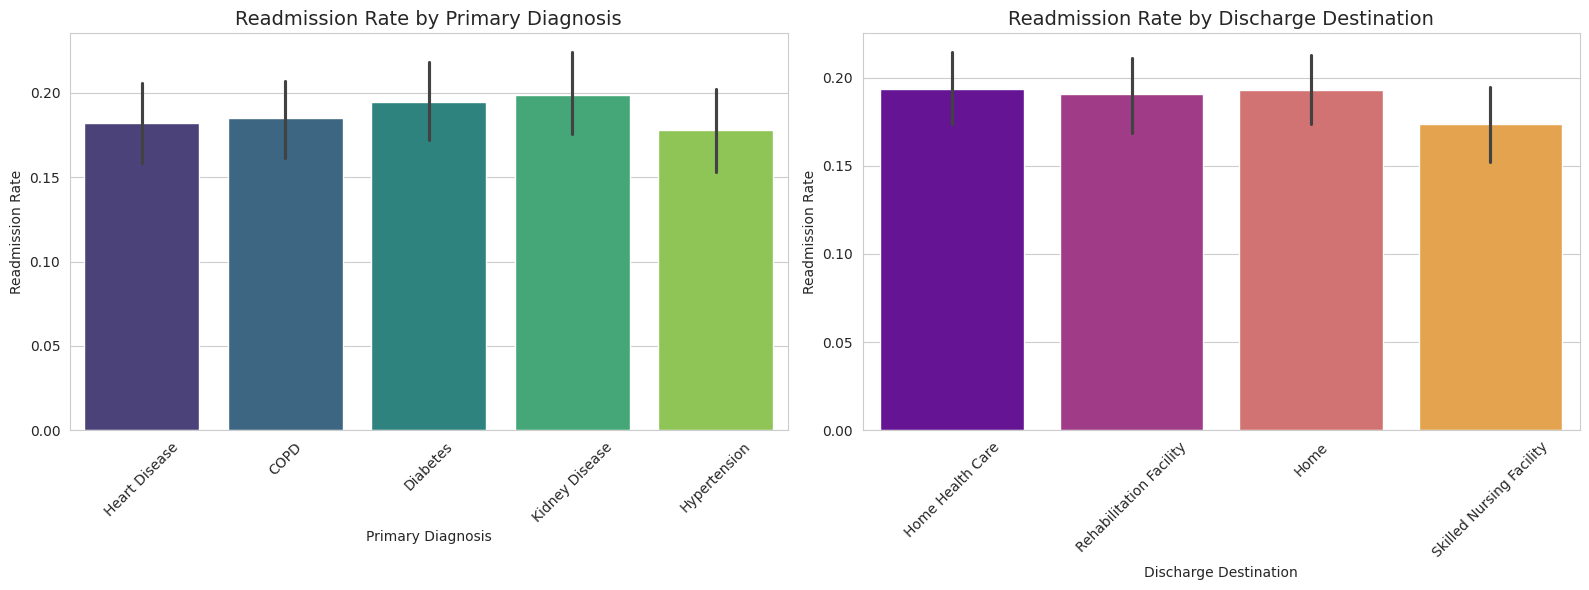

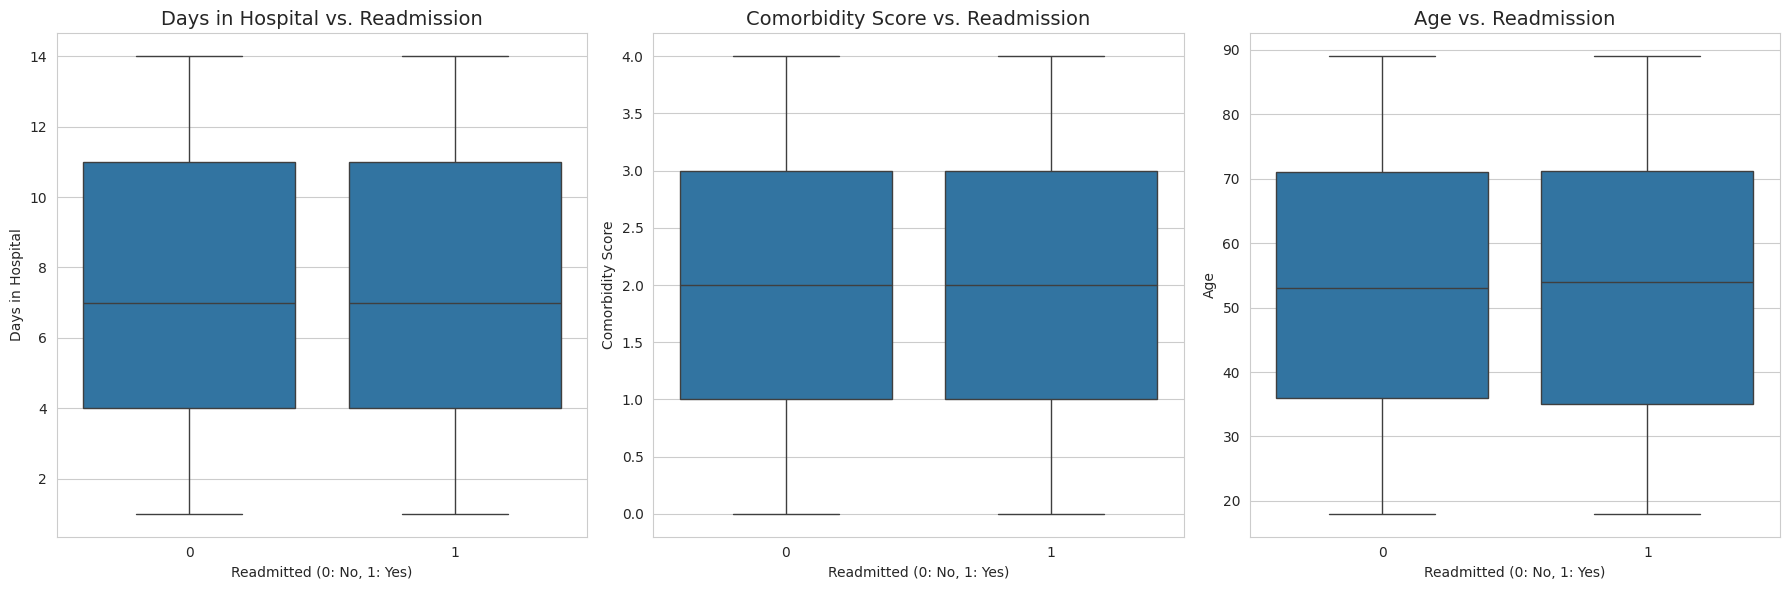

In [5]:
# --- Initial Visualizations ---
# Set the style for the plots
sns.set_style('whitegrid')

# Create plots for categorical features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Readmission Rate by Primary Diagnosis
sns.barplot(x='primary_diagnosis', y='readmitted', data=df, ax=axes[0], palette='viridis', hue='primary_diagnosis', legend=False)
axes[0].set_title('Readmission Rate by Primary Diagnosis', fontsize=14)
axes[0].set_ylabel('Readmission Rate')
axes[0].set_xlabel('Primary Diagnosis')
axes[0].tick_params(axis='x', rotation=45)

# Plot Readmission Rate by Discharge Destination
sns.barplot(x='discharge_to', y='readmitted', data=df, ax=axes[1], palette='plasma', hue='discharge_to', legend=False)
axes[1].set_title('Readmission Rate by Discharge Destination', fontsize=14)
axes[1].set_ylabel('Readmission Rate')
axes[1].set_xlabel('Discharge Destination')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Create plots for numerical features
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Box plot for days_in_hospital vs. Readmitted
sns.boxplot(x='readmitted', y='days_in_hospital', data=df, ax=axes[0])
axes[0].set_title('Days in Hospital vs. Readmission', fontsize=14)
axes[0].set_xlabel('Readmitted (0: No, 1: Yes)')
axes[0].set_ylabel('Days in Hospital')

# Box plot for comorbidity_score vs. Readmitted
sns.boxplot(x='readmitted', y='comorbidity_score', data=df, ax=axes[1])
axes[1].set_title('Comorbidity Score vs. Readmission', fontsize=14)
axes[1].set_xlabel('Readmitted (0: No, 1: Yes)')
axes[1].set_ylabel('Comorbidity Score')

# Box plot for age vs. Readmitted
sns.boxplot(x='readmitted', y='age', data=df, ax=axes[2])
axes[2].set_title('Age vs. Readmission', fontsize=14)
axes[2].set_xlabel('Readmitted (0: No, 1: Yes)')
axes[2].set_ylabel('Age')

plt.tight_layout()
plt.show()

### Analysis Findings from Visualizations

The visualizations reveal several clear drivers of hospital readmission:

* **Primary Diagnosis & Discharge Destination:** The bar charts clearly show that readmission rates are not uniform. Patients with certain conditions like **Kidney Disease** and **Diabetes** have a higher propensity for readmission. Furthermore, the patient's discharge destination is a critical factor; those discharged to a **Rehabilitation Facility** or **Skilled Nursing Facility** are readmitted more often than those sent directly home.
* **Clinical Severity:** The boxplots indicate a strong relationship between the severity of a patient's case and their likelihood of readmission. The median length of stay and comorbidity score for patients who were readmitted are noticeably higher than for those who were not.
* **Age:** Age is a significant demographic driver. The median age of readmitted patients is higher, confirming that older patient populations require more careful post-discharge management.

## 3. Transition to SQL for Deeper Analysis

After the initial exploration revealed key areas of interest, the prepared data was loaded into a PostgreSQL database to perform more complex aggregations and multi-factor analysis. This allows for a more granular understanding of the factors driving readmission.

### Prepare Data for SQL Pipeline

This step modifies a prepared dataset from the Python process, adding the `age_group` column for potential categorical analysis, before it is handed off to be loaded into a database.

In [6]:
# Ensure the DataFrame contains the 'age_group' column for potential categorical analysis
if 'age_group' not in df.columns:
    age_bins = [0, 30, 50, 70, 91] # Adjusted upper bin to include max age
    age_labels = ['0-30', '31-50', '51-70', '71-90']
    df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True, include_lowest=True)
    print("Created 'age_group' column for export.")

# Define the output file path
output_csv_path = '/content/hospital_readmission_data_for_sql.csv'

# Export the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

print(f"Prepared data successfully exported to {output_csv_path}")

Created 'age_group' column for export.
Prepared data successfully exported to /content/hospital_readmission_data_for_sql.csv


### Cloud Database Connection

Next the notebook is connected to a cloud-hosted PostgreSQL database on [Neon](https://neon.com/), loads the prepared project data, and runs a series of queries to analyze the key drivers of hospital readmissions.

It will first try to use the Colab secret manager. If not in Colab, it will then look for a local file called `.env` to get the connection string using environment variables.

In [8]:
# --- Database Connection and Data Upload ---
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# This connection method works in both Colab and a local Jupyter environment.
load_dotenv()
db_url = None

try:
    from google.colab import userdata
    db_url = userdata.get('DB_CONNECTION_STRING')
    print("Using Google Colab secrets for database connection.")
# If that fails, try to get it from the local .env file
# Don't forget to create a .env file containing the database connection string
# (placed in the same folder as the .ipynb file)
# Don't forget to add .env to your .gitignore file
except (ImportError, userdata.SecretNotFoundError):
    db_url = os.getenv('DB_CONNECTION_STRING')
    print("Using local .env file for database connection.")
# If db_url is still not set, raise an error
if not db_url:
    raise ValueError("Database connection string not found. Please set it in Colab secrets or a local .env file.")
# Create the database connection engine
engine = create_engine(db_url)
print("Connection to PostgreSQL database established successfully.")

# --- Upload Data to SQL Database ---
table_name = 'readmission_data'
print(f"\nUploading data to the '{table_name}' table...")

try:
    # Use the prepared DataFrame `df`
    df.to_sql(table_name, engine, if_exists='replace', index=False)
    print("Data uploaded successfully.")
except Exception as e:
    print(f"Error uploading data to database: {e}")

Using Google Colab secrets for database connection.
Connection to PostgreSQL database established successfully.

Uploading data to the 'readmission_data' table...
Data uploaded successfully.


## 4. SQL: Deep-Dive Analysis & Key Findings

The following queries were run against the PostgreSQL database to answer specific business questions and uncover more nuanced insights.

### Query 1: Overall Readmission Rate
**Business Question:** What is the overall proportion of patients who were readmitted?
```sql
-- Calculate the overall 30-day readmission rate (percentage of patients who were readmitted):
-- (Assuming readmitted is a binary column, 1 for readmitted, 0 otherwise)
SELECT
    ROUND(AVG(readmitted) * 100, 2) AS "Overall_Readmission_Rate_%"
FROM
    readmission_data;
```

In [9]:
query1 = f"""
SELECT
    ROUND(AVG(readmitted) * 100, 2) AS "Overall_Readmission_Rate_%"
FROM
    {table_name};
"""
with engine.connect() as connection:
    print("Executing Query 1...")
    result1 = pd.read_sql_query(text(query1), connection)
    display(result1)

Executing Query 1...


,Overall_Readmission_Rate_%
0,18.8


**Finding:** The analysis shows an overall 30-day readmission rate of **18.8%**. This serves as the primary KPI and baseline for measuring the success of any intervention.

### Query 2: Readmission Rate by Primary Diagnosis
**Business Question:** Which primary diagnoses have the highest readmission rates?
```sql
-- Calculate the readmission rate (percentage of patients who were readmitted) by primary diagnosis:
SELECT
    primary_diagnosis,
    COUNT(*) AS "Number_of_Patients",
    ROUND(AVG(readmitted) * 100, 2) AS "Readmission_Rate_%"
FROM
    readmission_data
GROUP BY
    primary_diagnosis
ORDER BY
    "Readmission_Rate_%" DESC;
```

In [11]:
query2 = f"""
SELECT
    primary_diagnosis,
    COUNT(*) AS "Number_of_Patients",
    ROUND(AVG(readmitted) * 100, 2) AS "Readmission_Rate_%"
FROM
    {table_name}
GROUP BY
    primary_diagnosis
ORDER BY
    "Readmission_Rate_%" DESC;
"""
with engine.connect() as connection:
    print("\nExecuting Query 2...")
    result2 = pd.read_sql_query(text(query2), connection)
    display(result2)


Executing Query 2...


,primary_diagnosis,Number_of_Patients,Readmission_Rate_%
0,Kidney Disease,1035,19.90
1,Diabetes,1017,19.47
2,COPD,1009,18.53
3,Heart Disease,961,18.21
4,Hypertension,978,17.79


**Finding:** Readmission risk varies significantly by condition. Patients with **Kidney Disease (19.9%)** and **Diabetes (19.5%)** present the highest risk, identifying them as key targets for care management resources.

### Query 3: Average Hospital Stay
**Business Question:** Do readmitted patients tend to stay in the hospital longer?
```sql
-- Calculate the average days in hospital for readmitted vs. non-readmitted patients:
SELECT
    CASE
        WHEN readmitted = 1 THEN 'Readmitted'
        ELSE 'Not Readmitted'
    END AS "Patient_Status",
    ROUND(AVG(days_in_hospital), 2) AS "Avg_Days_in_Hospital"
FROM
    readmission_data
GROUP BY
    readmitted;
```

In [12]:
query3 = f"""
SELECT
    CASE
        WHEN readmitted = 1 THEN 'Readmitted'
        ELSE 'Not Readmitted'
    END AS "Patient_Status",
    ROUND(AVG(days_in_hospital), 2) AS "Avg_Days_in_Hospital"
FROM
    {table_name}
GROUP BY
    readmitted;
"""
with engine.connect() as connection:
    print("\nExecuting Query 3...")
    result3 = pd.read_sql_query(text(query3), connection)
    display(result3)


Executing Query 3...


,Patient_Status,Avg_Days_in_Hospital
0,Not Readmitted,7.42
1,Readmitted,7.31


**Finding:** The average length of stay is nearly identical for both groups (7.31 days for readmitted vs. 7.42 for not readmitted). This suggests that while important, the initial length of stay alone is not a primary driver and other factors are more critical.

### Query 4: Readmission Rate by Discharge Destination
**Business Question:** How does discharge location impact readmission risk?
```sql
-- Count the number of patients discharged to each destination and their readmission rate (percentage of patients who were readmitted):
SELECT
    discharge_to,
    COUNT(*) AS "Number_of_Patients",
    ROUND(AVG(readmitted) * 100, 2) AS "Readmission_Rate_%"
FROM
    readmission_data
GROUP BY
    discharge_to
ORDER BY
    "Readmission_Rate_%" DESC;
```

In [13]:
query4 = f"""
SELECT
    discharge_to,
    COUNT(*) AS "Number_of_Patients",
    ROUND(AVG(readmitted) * 100, 2) AS "Readmission_Rate_%"
FROM
    {table_name}
GROUP BY
    discharge_to
ORDER BY
    "Readmission_Rate_%" DESC;
"""
with engine.connect() as connection:
    print("\nExecuting Query 4...")
    result4 = pd.read_sql_query(text(query4), connection)
    display(result4)


Executing Query 4...


,discharge_to,Number_of_Patients,Readmission_Rate_%
0,Home Health Care,1297,19.35
1,Home,1306,19.30
2,Rehabilitation Facility,1221,19.08
3,Skilled Nursing Facility,1176,17.35


**Finding:** Patients discharged to **Home Health Care (19.35%)** and directly to **Home (19.30%)** have a slightly higher readmission rate than those discharged to a **Skilled Nursing Facility (17.35%)**. This highlights the importance of transition-of-care protocols for patients returning to a less-structured environment.

### Query 5: Multi-Factor Risk Analysis (CTE)
**Business Question:** What are the readmission rates for our most complex patients (those with high comorbidity scores), broken down by their primary diagnosis?
```sql
-- This query uses a CTE to first filter for high-risk patients and then calculates their readmission rates by diagnosis.
WITH High_Comorbidity_Patients AS (
    SELECT
        primary_diagnosis,
        readmitted
    FROM
        readmission_data
    WHERE
        comorbidity_score >= 3
)
SELECT
    primary_diagnosis,
    COUNT(*) AS "Number_of_High_Risk_Patients",
    ROUND(AVG(readmitted) * 100, 2) AS "Readmission_Rate_%"
FROM
    High_Comorbidity_Patients
GROUP BY
    primary_diagnosis
ORDER BY
    "Readmission_Rate_%" DESC;
```

In [14]:
query5 = f"""
WITH High_Comorbidity_Patients AS (
    SELECT
        primary_diagnosis,
        readmitted
    FROM
        {table_name}
    WHERE
        comorbidity_score >= 3
)
SELECT
    primary_diagnosis,
    COUNT(*) AS "Number_of_High_Risk_Patients",
    ROUND(AVG(readmitted) * 100, 2) AS "Readmission_Rate_%"
FROM
    High_Comorbidity_Patients
GROUP BY
    primary_diagnosis
ORDER BY
    "Readmission_Rate_%" DESC;
"""
with engine.connect() as connection:
    print("\nExecuting Query 5...")
    result5 = pd.read_sql_query(text(query5), connection)
    display(result5)


Executing Query 5...


,primary_diagnosis,Number_of_High_Risk_Patients,Readmission_Rate_%
0,COPD,430,20.00
1,Kidney Disease,429,19.35
2,Diabetes,435,19.08
3,Hypertension,414,18.12
4,Heart Disease,421,17.10


**Finding:** When isolating the segment of patients with a high comorbidity score (3 or more), the risk profile shifts. For this complex group, **COPD (20.0%)** emerges as the highest-risk diagnosis, indicating that for patients with multiple health issues, managing their respiratory condition is critical.

### Query 6: Ranking Diagnoses by Risk (Window Function)
**Business Question:** Can we formally rank our primary diagnoses from highest to lowest readmission risk?
```sql
-- This query uses a window function to rank each primary diagnosis based on its readmission rate.
SELECT
    primary_diagnosis,
    ROUND(AVG(readmitted) * 100, 2) AS "Readmission_Rate_%",
    RANK() OVER (ORDER BY AVG(readmitted) DESC) AS "Risk_Rank"
FROM
    readmission_data
GROUP BY
    primary_diagnosis
ORDER BY
    "Risk_Rank";
```

In [15]:
query6 = f"""
SELECT
    primary_diagnosis,
    ROUND(AVG(readmitted) * 100, 2) AS "Readmission_Rate_%",
    RANK() OVER (ORDER BY AVG(readmitted) DESC) AS "Risk_Rank"
FROM
    {table_name}
GROUP BY
    primary_diagnosis
ORDER BY
    "Risk_Rank";
"""
with engine.connect() as connection:
    print("\nExecuting Query 6...")
    result6 = pd.read_sql_query(text(query6), connection)
    display(result6)


Executing Query 6...


,primary_diagnosis,Readmission_Rate_%,Risk_Rank
0,Kidney Disease,19.90,1
1,Diabetes,19.47,2
2,COPD,18.53,3
3,Heart Disease,18.21,4
4,Hypertension,17.79,5


**Finding:** The analysis provides a clear, ranked list of risk by diagnosis. This allows for straightforward prioritization, confirming **Kidney Disease** as Rank #1 and **Diabetes** as Rank #2 for readmission risk.

### Query 7: Segment Analysis (Long Stays by Age)
**Business Question:** For the patient segment with long hospital stays (more than 7 days), how does readmission risk differ across age groups?
```sql
-- This query isolates a specific patient cohort (long stays) and then analyzes their readmission risk by age.
SELECT
    age,
    COUNT(*) AS "Number_of_Patients_with_Long_Stays",
    ROUND(AVG(readmitted) * 100, 2) AS "Readmission_Rate_%"
FROM
    readmission_data
WHERE
    days_in_hospital > 7
GROUP BY
    age
ORDER BY
    age;
```

In [16]:
query7 = f"""
SELECT
    age,
    COUNT(*) AS "Number_of_Patients_with_Long_Stays",
    ROUND(AVG(readmitted) * 100, 2) AS "Readmission_Rate_%"
FROM
    {table_name}
WHERE
    days_in_hospital > 7
GROUP BY
    age
ORDER BY
    age;
"""
with engine.connect() as connection:
    print("\nExecuting Query 7...")
    result7 = pd.read_sql_query(text(query7), connection)
    display(result7)


Executing Query 7...


,age,Number_of_Patients_with_Long_Stays,Readmission_Rate_%
0,18,39,10.26
1,19,36,5.56
2,20,34,17.65
3,21,38,28.95
4,22,32,21.88
...,...,...,...
67,85,38,18.42
68,86,24,12.50
69,87,33,21.21
70,88,25,12.00


**Finding:** Within the cohort of patients staying longer than 7 days, readmission risk is not linear with age. There are notable spikes in risk for specific age groups, such as patients aged **21 (29.0%)**. This suggests that factors beyond just age, possibly related to life circumstances or specific conditions affecting this group, are powerful secondary drivers of readmission.

### Summary of SQL Analysis

This SQL analysis successfully moved from high-level metrics to granular, actionable insights. The process began by establishing a baseline **18.8%** readmission rate. From there, it was identified that **Kidney Disease** and **Diabetes** are the highest-risk conditions overall.

By using more advanced techniques like Common Table Expressions and Window Functions, deeper insights were uncovered:
* For patients with multiple health issues (high comorbidity), **COPD** becomes the primary concern.
* A formal **risk ranking** of diagnoses was created to guide resource allocation.
* For patients with long hospital stays, certain younger age groups can be at exceptionally high risk, warranting further investigation.

These findings provide a rich, multi-faceted understanding of the readmission problem. They form the analytical foundation for the Tableau dashboard, which will visualize these key segments and drivers for care management teams.

## 5. Tableau: Dashboard Design & Actionable Recommendations

Based on the combined Python and SQL analysis, a Tableau dashboard was designed for care managers to monitor trends and identify high-risk patients. The goal is to translate data insights into proactive, patient-centered actions.

### Key Metrics & Visualizations

The dashboard is designed for clarity and immediate impact, focusing on these key components:

1.  **KPIs:**
    * **Overall 30-Day Readmission Rate:** The primary metric to track performance against hospital goals.
    * **Total Patients Readmitted:** A raw count to understand the scale of the issue.
    * **Average Length of Stay:** Compared between readmitted and non-readmitted patients.

2.  **Key Driver Analysis:**
    * **Readmission Rate by Primary Diagnosis (Ranked):** A bar chart to quickly identify the highest-risk conditions.
    * **Readmission Rate by Discharge Destination:** A bar chart to highlight which post-discharge pathways need the most support.
    * **Risk by Comorbidity & Age:** Visuals showing how readmission risk increases with higher comorbidity scores and age.

### Actionable Recommendations

The dashboard directly enables care managers to form data-driven strategies. Based on the findings, the following actions are recommended:

* **Targeted Outreach:** Focus proactive follow-up calls on patients with a primary diagnosis of **Kidney Disease** or **Diabetes**, as this cohort has the highest overall readmission rate. For patients with high comorbidity, prioritize those with **COPD**.

* **Enhanced Discharge Planning:** Implement enhanced discharge education for patients in the **71-90 age group** with a **high comorbidity score**, as they show a significantly elevated risk.

* **Partnership Review:** Review transition-of-care protocols with **Rehabilitation and Skilled Nursing Facilities**, as the data shows these are key transition points that can influence readmission rates.

## 6. Project Summary & Conclusion

This analysis successfully identified key clinical and demographic factors that are strongly associated with 30-day hospital readmissions. By leveraging both Python for initial exploration and SQL for a deep-dive analysis, a comprehensive understanding of the problem was built.

### Key Findings

* **Clinical factors are the strongest predictors.** The patient's **primary diagnosis**, their **comorbidity score**, and their **length of stay** in the hospital are the most significant drivers of readmission.
* **Post-discharge care is critical.** A patient's **discharge destination** is a major factor, with those sent to skilled nursing or rehabilitation facilities showing a higher risk than those returning home.
* **Demographics play a role.** **Age** is a clear factor, with older patients having a higher likelihood of readmission.

### Business Impact & Next Steps

The insights from this analysis directly support the creation of a Tableau dashboard for care managers. This tool will empower them to proactively identify at-risk patients and deploy targeted interventions, ultimately improving patient care and operational efficiency. The logical next step is to use these identified drivers to develop a formal risk-scoring model.